In [ ]:
#resources 
#https://towardsdatascience.com/building-an-image-color-analyzer-using-python-12de6b0acf74

In [1]:
from collections import Counter
from sklearn.cluster import KMeans
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import cv2
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import colorsys
import os
from fake_useragent import UserAgent

from time import sleep
import json

import contractions
import spacy
#from spacy.tokenizer import Tokenizer
import en_core_web_sm
import nltk
#from nltk.stem import WordNetLemmatizer
from nltk import bigrams, trigrams
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import requests
import string
import regex as re
import collections

In [5]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
ua = UserAgent()
userAgent = ua.random

In [3]:
def rgb_to_hex(rgb_color):
    hex_color = "#"
    for i in rgb_color:
        i = int(i)
        hex_color += ("{:02x}".format(i))
    return hex_color

def prep_image(raw_img):
    modified_img = cv2.resize(raw_img, (900, 600), interpolation = cv2.INTER_AREA)
    modified_img = modified_img.reshape(modified_img.shape[0]*modified_img.shape[1], 3)
    return modified_img

def color_analysis(img, url, k=5):
    
    clf = KMeans(n_clusters = k)
    color_labels = clf.fit_predict(img)
    center_colors = clf.cluster_centers_    
    counts = Counter(color_labels)
    ordered_colors = [center_colors[i].round(3).tolist() for i in counts.keys()]
    hex_colors = [rgb_to_hex(ordered_colors[i]) for i in counts.keys()]    
    plt.figure(figsize = (12, 8))
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    plt.title('color proportions from {u}'.format(u=url))
    plt.savefig('./plots/pie-' + url.replace('.', '-') + '.png')
    
    
    
    color_array = np.array(list(counts.values()))
    color_proportion = (color_array/sum(color_array)).round(3).tolist()
 
    
    color_dict = {}
    
    color_dict['centroids_rgb'] = ordered_colors
    color_dict['centroids_hex'] = hex_colors
    color_dict['color_counts'] = color_array.tolist()
    color_dict['color_proportion'] = color_proportion
    
    hsv = [list(colorsys.rgb_to_hsv(c[0], c[1], c[2])) for c in color_dict['centroids_rgb']]
    color_dict['centroids_hsv']=hsv
    
    #print(hex_colors)
    return color_dict 

In [4]:
def get_paragraph_text(url, hdr):
    
    try:
        
        req = Request(url,headers=hdr)
        page = urlopen(req)
    
    except:
        
        print("http failed, trying https:")
        
        try:
            url = url.replace('http:', 'https:')
            req = Request(url,headers=hdr)
            page = urlopen(req)
        
        except Exception as e:
            print("substitution of https also failed. Error is {}".format(e))
            
    else:
   
        soup = BeautifulSoup(page, 'html.parser')

        p=soup.find_all('p')
        text = ' '.join(t.get_text() for t in p)

        return text

class TextPreprocessor(object):
    def __init__(self):
        """
        TBD
        """

    def preprocess_df(self, df):
        return df.apply(self._preprocess_text)

    def preprocess_text(self, text):
        doc = nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)

        return self._lemmatize(removed_stop_words)

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        
        lemma_text = ' '.join([t.lemma_ for t in doc])
        
        return re.sub('\s+',' ',lemma_text)
        


In [6]:
urls = ['www.uber.com', 'www.lyft.com', 'www.doordash.com']
#urls = ['www.lyft.com']



====== WebDriver manager ======
Current google-chrome version is 101.0.4951
Get LATEST chromedriver version for 101.0.4951 google-chrome
Driver [/Users/amywinecoff/.wdm/drivers/chromedriver/mac64/101.0.4951.41/chromedriver] found in cache


sans-serif
rgba(0, 0, 0, 0)
rgba(0, 0, 0, 1)
sans-serif
16px
ProximaNova, sans-serif
rgba(255, 255, 255, 1)
rgba(12, 11, 49, 1)
ProximaNova, sans-serif
16px
"Times New Roman"
rgba(0, 0, 0, 0)
rgba(0, 0, 0, 1)
"Times New Roman"
16px
end...


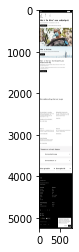

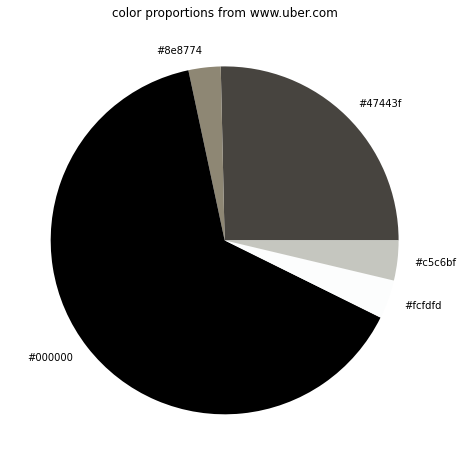

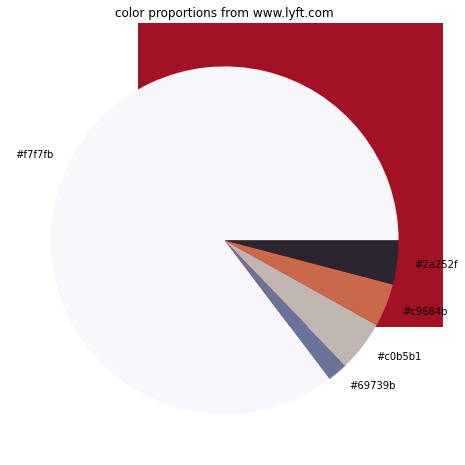

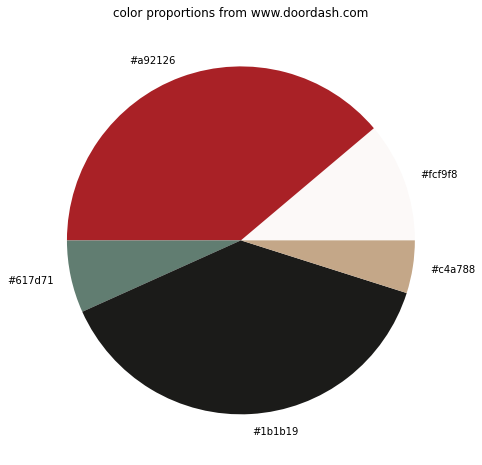

In [7]:
options = webdriver.ChromeOptions()
options.headless = True
options.add_argument(f'user-agent={userAgent}')
    
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
driver.maximize_window()
url_errors = {}
urls_color_dicts = []

#if the json already exists from a prior code run, delete it
if os.path.exists('site_screenshot_colors.json'):
    os.remove('site_screenshot_colors.json')

for url in urls:
    
    try:
        
    
        #driver.get('https://' + url)
        
        sleep(2)
        #driver.get_screenshot_as_file('./site-screenshots/'+ url.replace('.', '-') + '.png')
        
        #driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
        driver.get('https://' + url)
        sleep(2)
        #el = driver.find_element_by_tag_name('body')
        #el = driver.find_element(By.TAG_NAME, value='body')

        S = lambda X: driver.execute_script('return document.body.parentNode.scroll'+X)
        driver.set_window_size(S('Width'),S('Height')) # May need manual adjustment

        el = driver.find_element(By.TAG_NAME, value='body')
        el.screenshot('./site-screenshots/'+ url.replace('.', '-') + '.png')

        image = cv2.imread('./site-screenshots/'+ url.replace('.', '-') + '.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)

        modified_image = prep_image(image)
        color_dict = color_analysis(modified_image, url)
        color_dict['url'] = url
        color_dict['screenshot'] = url.replace('.', '-') + '.png'
        
        
        
        with open('site_screenshot_colors.json', 'a') as f:
            f.write(json.dumps(color_dict))
            f.write('\n')
            #f.close()
            #file.seek(0)
            #json.dump(color_dict, file)
                                      

        urls_color_dicts.append(color_dict)
        
        #font family is probably not reliable
        print(el.value_of_css_property("font-family"))
        print(el.value_of_css_property("background-color"))
        print(el.value_of_css_property("color"))
        print(el.value_of_css_property("font-family"))
        print(el.value_of_css_property("font-size"))
        
        
        
                
    
    except Exception as e:
        
        print("url {url} error {e}".format(url=url, e=e))
        
        url_errors[url] = e

driver.quit()
f.close()

print("end...")

In [ ]:
urls_color_dicts

In [ ]:
# element.value_of_css_property(property_name)
# driver.get("https://google.com")
# cssValue = driver.find_element_by_name("q").value_of_css_property("font-size")
#hsv = [colorsys.rgb_to_hsv(c) for c in color_dict['centroids_rgb']]

# for c in color_dict['centroids_rgb']:
#     #print(c[0], c[1], c[2])
#     print(tuple(c))
#     #print(list(colorsys.rgb_to_hsv(c[0], c[1], c[2])))
#     print(colorsys.rgb_to_hsv(tuple(c)))
#hsv = [list(colorsys.rgb_to_hsv(c[0], c[1], c[2])) for c in color_dict['centroids_rgb']]

In [ ]:
full_url = "http://" + url
hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}

req = Request(full_url,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page, 'html.parser')

main_site_text = get_paragraph_text(full_url, hdr).lower()
#print(main_site_text)

processed_text = TextPreprocessor().preprocess_text(main_site_text)
print(processed_text)

word_counts = collections.Counter(processed_text.split())
# bg = bigrams(ah_text.split())
# bigram_counts = collections.Counter(bg)
# tg = trigrams(ah_text.split())
# trigram_counts = collections.Counter(tg)

word_counts.most_common(50)


In [ ]:
bigram_counts.most_common(50)



In [ ]:
print(soup.prettify())

In [ ]:
#element = driver.find_element_by_tag_name('title')
element = driver.find_element(By.TAG_NAME, value='title')
"/html/body"
properties = driver.execute_script('return window.getComputedStyle(arguments[0], null);', element)
for property in properties:
    print(property, element.value_of_css_property(property))

In [ ]:
#element = driver.find_element(By.XPATH, "/html/body")
#element = driver.find_element(By.TAG_NAME, value='title')

print(el.value_of_css_property("background-color"))
print(el.value_of_css_property("color"))
print(el.value_of_css_property("font-family"))
print(el.value_of_css_property("font-size"))

In [ ]:
element = driver.find_element(By.XPATH, "/html/body")
properties = driver.execute_script('return window.getComputedStyle(arguments[0], null);', element)
for property in properties:
    print(property, element.value_of_css_property(property))

In [ ]:
spacy.language

In [ ]:
colorsys.rgb_to_hsv(.3, .4, .2)

In [ ]:
#are the rgb values, cluster centroids, cluster centroid proportions, or hsv values predictive of the type of business